In [33]:
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [34]:
#preprocessing
df_iot = pd.read_csv(
    "/content/drive/MyDrive/hh101.csv",
    sep=r"\t+",
    header=None,
    engine="python",
    names=["date","time","sensor","state","label"]
)

split_cols = df_iot.iloc[:, 0].str.split(",", n=4, expand=True)

split_cols.columns = ["date", "time", "sensor", "state", "label"]

df_iot = split_cols

df_iot["timestamp"] = pd.to_datetime(df_iot["date"] + " " + df_iot["time"])
df_iot = df_iot.drop(columns=["date", "time"])
df_iot = df_iot.sort_values("timestamp")

df_iot.head()


,sensor,state,label,timestamp
0,OutsideDoor,ON,"Step_Out=""begin""",2012-07-20 10:38:54.512364
1,OutsideDoor,OFF,None,2012-07-20 10:38:59.541365
2,OutsideDoor,ON,None,2012-07-20 10:39:02.429671
3,OutsideDoor,OFF,None,2012-07-20 10:39:04.120443
4,OutsideDoor,ON,None,2012-07-20 10:39:36.167078


In [ ]:
df_iot["event"] = df_iot["sensor"] + "_" + df_iot["state"]

df_iot = df_iot.set_index("timestamp")

X = pd.get_dummies(df_iot["event"]).resample("10s").max().fillna(0)

In [36]:
X.head()

,Bathroom_OFF,Bathroom_ON,Bedroom_OFF,Bedroom_ON,DiningRoom_OFF,DiningRoom_ON,Kitchen_OFF,Kitchen_ON,LivingRoom_OFF,LivingRoom_ON,OutsideDoor_CLOSE,OutsideDoor_OFF,OutsideDoor_ON,OutsideDoor_OPEN
timestamp,,,,,,,,,,,,,,
2012-07-20 10:38:50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2012-07-20 10:39:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2012-07-20 10:39:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-20 10:39:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-07-20 10:39:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
SEQ_LEN = 60 
data = X.values.astype("float32")

sequences = []
for i in range(len(data) - SEQ_LEN):
    sequences.append(data[i:i+SEQ_LEN])

sequences = np.array(sequences)
print(sequences.shape)


(514467, 60, 14)


In [38]:
train_size = int(len(sequences) * 0.7)
X_train = sequences[:train_size]
X_test  = sequences[train_size:]

import tensorflow as tf
from tensorflow.keras import layers, models

timesteps = X_train.shape[1]
features  = X_train.shape[2]

inputs = layers.Input(shape=(timesteps, features))

# Encoder
encoded = layers.LSTM(128, return_sequences=True)(inputs)
encoded = layers.LSTM(64)(encoded)

# Decoder
decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(64, return_sequences=True)(decoded)
decoded = layers.LSTM(128, return_sequences=True)(decoded)
outputs = layers.TimeDistributed(layers.Dense(features))(decoded)

autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 14)         │         1,806 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,270 (1001.05 KB)

 Trainable params: 256,270 (1001.05 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1998s 393ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 2/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1992s 391ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 3/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1997s 390ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 4/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1970s 389ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 5/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1979s 391ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 2014s 393ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 7/25
5065/5065 ━━━━━━━━━━━━━━━━━━━━ 1966s 388ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 8/25
1358/5065 ━━━━━━━━━━━━━━━━━━━━ 23:32 381ms/step - loss: 0.0045

KeyboardInterrupt: 

In [50]:
X_test_pred = autoencoder.predict(X_test)

recon_error = np.mean(np.square(X_test_pred - X_test), axis=(1,2))

threshold = np.mean(recon_error) + 5.5 * np.std(recon_error)

anomalies = recon_error > threshold

timestamps = X.index[SEQ_LEN + train_size:]
results = pd.DataFrame({
    "timestamp": timestamps,
    "reconstruction_error": recon_error,
    "anomaly": anomalies
})


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 403s 83ms/step


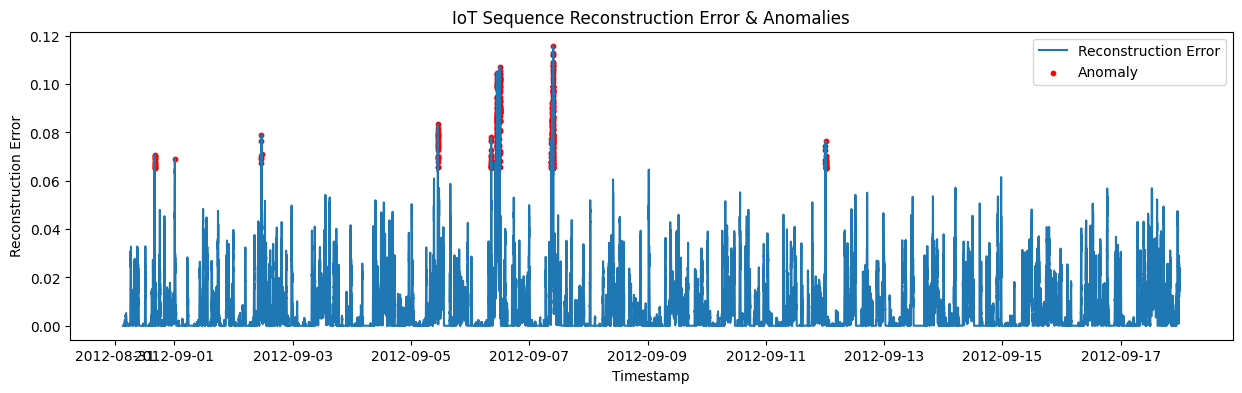

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(results["timestamp"], results["reconstruction_error"], label="Reconstruction Error")
plt.scatter(
    results["timestamp"][results["anomaly"]],
    results["reconstruction_error"][results["anomaly"]],
    color="red", label="Anomaly", s=10
)
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error")
plt.title("IoT Sequence Reconstruction Error & Anomalies")
plt.legend()
plt.show()
